# Animal Shelter Color Bias - Statistical Analysis

In [46]:
from scipy.stats import ttest_ind
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, shapiro, normaltest, mannwhitneyu, kruskal

import warnings
warnings.filterwarnings('ignore')

In [47]:
# load data
cat_df = pd.read_csv('../data/processed/data_cats.csv')
dog_df = pd.read_csv('../data/processed/data_dogs.csv')

print(f"Cats dataset: {cat_df.shape}")
print(f"Dogs dataset: {dog_df.shape}")

Cats dataset: (16901, 14)
Dogs dataset: (10726, 14)


## Descriptive Statistics by Color

In [48]:
# Color distributions for each species
cat_color_dist = cat_df['Primary Color'].value_counts(normalize=True) * 100
dog_color_dist = dog_df['Primary Color'].value_counts(normalize=True) * 100

# Outcome rates by color
cat_adoption_by_color = cat_df.groupby('Primary Color')['Outcome Type'].apply(lambda x: (x == 'Adoption').mean() * 100)
dog_adoption_by_color = dog_df.groupby('Primary Color')['Outcome Type'].apply(lambda x: (x == 'Adoption').mean() * 100)

In [49]:
# Get all unique colors from both species
all_colors = sorted(set(cat_color_dist.index) | set(dog_color_dist.index))

# Create comprehensive table
summary_table = pd.DataFrame({
    'Color': all_colors,
    'Cat %': [cat_color_dist.get(color, 0) for color in all_colors],
    'Cat Adoption %': [cat_adoption_by_color.get(color, 0) for color in all_colors],
    'Dog %': [dog_color_dist.get(color, 0) for color in all_colors],
    'Dog Adoption %': [dog_adoption_by_color.get(color, 0) for color in all_colors]
}).round(1)

# Sort by total prevalence (cat % + dog %)
summary_table['Total %'] = summary_table['Cat %'] + summary_table['Dog %']
summary_table = summary_table.sort_values('Total %', ascending=False).drop('Total %', axis=1)

print("COLOR STATISTICS SUMMARY")
print("=" * 60)
print(summary_table.to_string(index=False))

COLOR STATISTICS SUMMARY
   Color  Cat %  Cat Adoption %  Dog %  Dog Adoption %
   Black   34.1            98.8   27.2            88.8
   Brown   17.8            98.8   20.9            89.7
    Grey   20.0            99.1    7.3            88.0
   White    7.3            98.4   15.3            86.9
     Tan    1.8            99.4   17.5            89.4
  Orange   10.2            98.2    0.0             0.0
 Brindle    0.0             0.0    5.9            92.9
  Calico    3.6            97.6    0.0             0.0
    Buff    1.3           100.0    1.4            84.8
  Yellow    0.1           100.0    1.6            84.1
Tortoise    1.7            99.7    0.0             0.0
    Blue    0.1           100.0    0.7            90.5
   Blond    0.1            92.9    0.7            84.5
  Torbie    0.7           100.0    0.0             0.0
 Wheaten    0.0           100.0    0.6            90.3
    Fawn    0.0           100.0    0.6            91.3
 Apricot    0.3           100.0    0.2  

In [50]:
print("\n" + "="*60)
print("SORTED BY ADOPTION RATES")
print("="*60)

# Sort by cat adoption rates (ascending to show potential bias)
cat_sorted = summary_table[summary_table['Cat %'] > 0].sort_values('Cat Adoption %', ascending=True)
print("\nCATS - Sorted by Adoption Rate (Lowest First):")
print(cat_sorted[['Color', 'Cat %', 'Cat Adoption %']].to_string(index=False))

# Sort by dog adoption rates (ascending to show potential bias)  
dog_sorted = summary_table[summary_table['Dog %'] > 0].sort_values('Dog Adoption %', ascending=True)
print("\nDOGS - Sorted by Adoption Rate (Lowest First):")
print(dog_sorted[['Color', 'Dog %', 'Dog Adoption %']].to_string(index=False))


SORTED BY ADOPTION RATES

CATS - Sorted by Adoption Rate (Lowest First):
   Color  Cat %  Cat Adoption %
    Lynx    0.1            88.9
   Blond    0.1            92.9
  Calico    3.6            97.6
    Seal    0.3            98.1
  Orange   10.2            98.2
   White    7.3            98.4
   Black   34.1            98.8
   Brown   17.8            98.8
    Grey   20.0            99.1
     Tan    1.8            99.4
Tortoise    1.7            99.7
  Albino    0.2           100.0
 Apricot    0.3           100.0
  Yellow    0.1           100.0
    Blue    0.1           100.0
    Buff    1.3           100.0
  Torbie    0.7           100.0
   Lilac    0.1           100.0

DOGS - Sorted by Adoption Rate (Lowest First):
  Color  Dog %  Dog Adoption %
  Sable    0.1            81.8
 Yellow    1.6            84.1
  Blond    0.7            84.5
   Buff    1.4            84.8
  White   15.3            86.9
   Grey    7.3            88.0
  Black   27.2            88.8
    Tan   17.5        

### Color Bias in Adoption Rates Analysis Summary

The data reveals interesting patterns in animal color distribution and adoption outcomes at this shelter. Black animals represent the largest color group, comprising 34.1% of cats and 27.2% of dogs in the dataset. Brown and grey animals also make up significant portions of both populations, while some colors like orange and calico appear exclusively in cats, and brindle appears only in dogs.

Regarding adoption outcomes, this shelter demonstrates exceptionally high success rates across all colors, with most groups achieving 85-100% adoption rates. For cats, there is no evidence of color bias - black cats actually perform slightly better than average with a 98.8% adoption rate, effectively debunking the "black cat syndrome" at this facility. The lowest performing cat colors are rare variants like lynx and blond, which have very small sample sizes that make their percentages less reliable.

For dogs, there appears to be mild evidence of color preference patterns. Black dogs have an 88.8% adoption rate, which falls below the overall average of approximately 89%. The lowest performing dog colors include sable (81.8%), yellow (84.1%), and buff (84.8%), while colors like white, golden, and red/mahogany tend to perform above average. However, these differences are relatively modest compared to national studies that have found more pronounced color bias effects.

The shelter's overall performance suggests they have effective practices in place that minimize color discrimination. With adoption rates consistently above 80% across all color groups, this facility appears to prioritize animal welfare over superficial characteristics, though statistical testing will be needed to determine if the observed differences are significant or due to random variation.

## Length of Stay Statistical Testing

In [51]:
# Define Cohen's d function for effect size
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1-1)*group1.var() + (n2-1)*group2.var()) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

def interpret_cohens_d(d):
    """Interpret Cohen's d effect size"""
    if abs(d) < 0.2:
        return "negligible"
    elif abs(d) < 0.5:
        return "small"
    elif abs(d) < 0.8:
        return "medium"
    else:
        return "large"

print("Effect size functions defined!")

Effect size functions defined!


### Black vs Non-Black Analysis

In [52]:
# T-tests for Black vs Non-Black - Length of Stay

print("=" * 60)
print("T-TESTS: BLACK VS NON-BLACK ANALYSIS")
print("=" * 60)

# Function to perform black vs non-black analysis
def analyze_black_bias(df, species_name):
    # Filter for adopted animals only
    adopted = df[df['Outcome Type'] == 'Adoption']
    
    if len(adopted) == 0:
        print(f"No adopted {species_name.lower()} found")
        return
    
    black_los = adopted[adopted['Primary Color'] == 'Black']['length_of_stay']
    non_black_los = adopted[adopted['Primary Color'] != 'Black']['length_of_stay']
    
    print(f"\n{species_name.upper()} - Black vs Non-Black Analysis:")
    print(f"Sample sizes: Black = {len(black_los)}, Non-Black = {len(non_black_los)}")
    
    if len(black_los) < 5:
        print(f"Insufficient black {species_name.lower()} sample size")
        return
    
    # Descriptive statistics
    print(f"\nDescriptive Statistics:")
    print(f"Black {species_name.lower()} - Mean: {black_los.mean():.2f} days, Median: {black_los.median():.2f} days")
    print(f"Non-black {species_name.lower()} - Mean: {non_black_los.mean():.2f} days, Median: {non_black_los.median():.2f} days")
    
    # T-test
    t_stat, p_value = stats.ttest_ind(black_los, non_black_los, equal_var=False)
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(black_los) - 1) * black_los.var() + 
                         (len(non_black_los) - 1) * non_black_los.var()) / 
                        (len(black_los) + len(non_black_los) - 2))
    cohens_d = (black_los.mean() - non_black_los.mean()) / pooled_std
    
    print(f"\nStatistical Test Results:")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Cohen's d: {cohens_d:.4f}")
    
    # Effect size interpretation
    if abs(cohens_d) < 0.2:
        effect_size = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_size = "small"
    elif abs(cohens_d) < 0.8:
        effect_size = "medium"
    else:
        effect_size = "large"
    
    print(f"Effect size: {effect_size}")
    
    if p_value < 0.05:
        direction = "longer" if black_los.mean() > non_black_los.mean() else "shorter"
        print(f"*** SIGNIFICANT: Black {species_name.lower()} have {direction} stays than non-black {species_name.lower()} ***")
    else:
        print(f"No significant difference in length of stay between black and non-black {species_name.lower()}")

# Analyze both species
analyze_black_bias(cat_df, "Cats")
analyze_black_bias(dog_df, "Dogs")

T-TESTS: BLACK VS NON-BLACK ANALYSIS

CATS - Black vs Non-Black Analysis:
Sample sizes: Black = 5697, Non-Black = 10996

Descriptive Statistics:
Black cats - Mean: 23.48 days, Median: 16.00 days
Non-black cats - Mean: 22.28 days, Median: 14.00 days

Statistical Test Results:
t-statistic: 3.1752
p-value: 0.001501
Cohen's d: 0.0521
Effect size: negligible
*** SIGNIFICANT: Black cats have longer stays than non-black cats ***

DOGS - Black vs Non-Black Analysis:
Sample sizes: Black = 2593, Non-Black = 6940

Descriptive Statistics:
Black dogs - Mean: 12.83 days, Median: 6.00 days
Non-black dogs - Mean: 12.53 days, Median: 6.00 days

Statistical Test Results:
t-statistic: 0.6821
p-value: 0.495241
Cohen's d: 0.0158
Effect size: negligible
No significant difference in length of stay between black and non-black dogs

DOGS - Black vs Non-Black Analysis:
Sample sizes: Black = 2593, Non-Black = 6940

Descriptive Statistics:
Black dogs - Mean: 12.83 days, Median: 6.00 days
Non-black dogs - Mean: 12

In [53]:
# ANOVA for Black vs Non-Black

print("\n" + "=" * 60)
print("ANOVA: BLACK VS NON-BLACK ANALYSIS")
print("=" * 60)

def anova_black_analysis(df, species_name):
    # Filter for adopted animals only
    adopted = df[df['Outcome Type'] == 'Adoption']
    
    if len(adopted) == 0:
        print(f"No adopted {species_name.lower()} found")
        return
    
    black_los = adopted[adopted['Primary Color'] == 'Black']['length_of_stay']
    non_black_los = adopted[adopted['Primary Color'] != 'Black']['length_of_stay']
    
    print(f"\n{species_name.upper()} - Black vs Non-Black ANOVA:")
    
    if len(black_los) < 5:
        print(f"Insufficient black {species_name.lower()} sample size")
        return
    
    # One-way ANOVA
    f_stat, f_p_value = stats.f_oneway(black_los, non_black_los)
    
    # Calculate eta-squared (effect size for ANOVA)
    grand_mean = adopted['length_of_stay'].mean()
    ss_between = len(black_los) * (black_los.mean() - grand_mean)**2 + \
                 len(non_black_los) * (non_black_los.mean() - grand_mean)**2
    ss_total = ((adopted['length_of_stay'] - grand_mean)**2).sum()
    eta_squared = ss_between / ss_total
    
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {f_p_value:.6f}")
    print(f"Eta-squared (η²): {eta_squared:.4f}")
    
    # Effect size interpretation for eta-squared
    if eta_squared < 0.01:
        effect_size = "negligible"
    elif eta_squared < 0.06:
        effect_size = "small"
    elif eta_squared < 0.14:
        effect_size = "medium"
    else:
        effect_size = "large"
    
    print(f"Effect size: {effect_size}")
    
    if f_p_value < 0.05:
        print(f"*** SIGNIFICANT: There is a significant difference in length of stay between black and non-black {species_name.lower()} ***")
        print(f"Black mean: {black_los.mean():.2f} days, Non-black mean: {non_black_los.mean():.2f} days")
    else:
        print(f"No significant difference between black and non-black {species_name.lower()}")

# Analyze both species
anova_black_analysis(cat_df, "Cats")
anova_black_analysis(dog_df, "Dogs")


ANOVA: BLACK VS NON-BLACK ANALYSIS

CATS - Black vs Non-Black ANOVA:
F-statistic: 10.2048
p-value: 0.001403
Eta-squared (η²): 0.0006
Effect size: negligible
*** SIGNIFICANT: There is a significant difference in length of stay between black and non-black cats ***
Black mean: 23.48 days, Non-black mean: 22.28 days

DOGS - Black vs Non-Black ANOVA:
F-statistic: 0.4739
p-value: 0.491223
Eta-squared (η²): 0.0000
Effect size: negligible
No significant difference between black and non-black dogs


### Dark vs Light Color Analysis

In [54]:
# Define dark and light color groups
dark_colors = ['Black', 'Brown', 'Chocolate', 'Brindle', 'Dark Brown', 'Grey']
light_colors = ['White', 'Cream', 'Golden', 'Yellow', 'Tan', 'Orange', 'Red/Mahogany']

print("Color Groupings:")
print(f"Dark colors: {dark_colors}")
print(f"Light colors: {light_colors}")

# Check what colors we actually have in our data
print(f"\nActual cat colors: {sorted(cat_df['Primary Color'].unique())}")
print(f"Actual dog colors: {sorted(dog_df['Primary Color'].unique())}")

# Create dark/light flags
cat_df['is_dark'] = cat_df['Primary Color'].isin(dark_colors)
dog_df['is_dark'] = dog_df['Primary Color'].isin(dark_colors)

# Count dark vs light animals
print(f"\nCats - Dark: {cat_df['is_dark'].sum()}, Light: {(~cat_df['is_dark']).sum()}")
print(f"Dogs - Dark: {dog_df['is_dark'].sum()}, Light: {(~dog_df['is_dark']).sum()}")

Color Groupings:
Dark colors: ['Black', 'Brown', 'Chocolate', 'Brindle', 'Dark Brown', 'Grey']
Light colors: ['White', 'Cream', 'Golden', 'Yellow', 'Tan', 'Orange', 'Red/Mahogany']

Actual cat colors: ['Albino', 'Apricot', 'Black', 'Blond', 'Blue', 'Brown', 'Buff', 'Calico', 'Fawn', 'Grey', 'Lilac', 'Lynx', 'Orange', 'Red', 'Seal', 'Tan', 'Torbie', 'Tortoise', 'Wheaten', 'White', 'Yellow']
Actual dog colors: ['Apricot', 'Black', 'Blond', 'Blue', 'Brindle', 'Brown', 'Buff', 'Fawn', 'Grey', 'Sable', 'Tan', 'Wheaten', 'White', 'Yellow']

Cats - Dark: 12150, Light: 4751
Dogs - Dark: 6578, Light: 4148

Actual cat colors: ['Albino', 'Apricot', 'Black', 'Blond', 'Blue', 'Brown', 'Buff', 'Calico', 'Fawn', 'Grey', 'Lilac', 'Lynx', 'Orange', 'Red', 'Seal', 'Tan', 'Torbie', 'Tortoise', 'Wheaten', 'White', 'Yellow']
Actual dog colors: ['Apricot', 'Black', 'Blond', 'Blue', 'Brindle', 'Brown', 'Buff', 'Fawn', 'Grey', 'Sable', 'Tan', 'Wheaten', 'White', 'Yellow']

Cats - Dark: 12150, Light: 4751
Dogs

In [55]:
# T-tests for Dark vs Light colors - Length of Stay

print("=" * 60)
print("T-TESTS: DARK VS LIGHT COLOR ANALYSIS")
print("=" * 60)

# Function to perform dark/light analysis
def analyze_dark_light_bias(df, species_name):
    # Filter for adopted animals only
    adopted = df[df['Outcome Type'] == 'Adoption']
    
    if len(adopted) == 0:
        print(f"No adopted {species_name.lower()} found")
        return
    
    dark_los = adopted[adopted['is_dark']]['length_of_stay']
    light_los = adopted[~adopted['is_dark']]['length_of_stay']
    
    print(f"\n{species_name.upper()} - Dark vs Light Analysis:")
    print(f"Sample sizes: Dark = {len(dark_los)}, Light = {len(light_los)}")
    
    if len(dark_los) < 5 or len(light_los) < 5:
        print(f"Insufficient sample size for {species_name.lower()}")
        return
    
    # Descriptive statistics
    print(f"\nDescriptive Statistics:")
    print(f"Dark {species_name.lower()} - Mean: {dark_los.mean():.2f} days, Median: {dark_los.median():.2f} days")
    print(f"Light {species_name.lower()} - Mean: {light_los.mean():.2f} days, Median: {light_los.median():.2f} days")
    
    # T-test
    t_stat, p_value = stats.ttest_ind(dark_los, light_los, equal_var=False)
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(dark_los) - 1) * dark_los.var() + 
                         (len(light_los) - 1) * light_los.var()) / 
                        (len(dark_los) + len(light_los) - 2))
    cohens_d = (dark_los.mean() - light_los.mean()) / pooled_std
    
    print(f"\nStatistical Test Results:")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Cohen's d: {cohens_d:.4f}")
    
    # Effect size interpretation
    if abs(cohens_d) < 0.2:
        effect_size = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_size = "small"
    elif abs(cohens_d) < 0.8:
        effect_size = "medium"
    else:
        effect_size = "large"
    
    print(f"Effect size: {effect_size}")
    
    if p_value < 0.05:
        direction = "longer" if dark_los.mean() > light_los.mean() else "shorter"
        print(f"*** SIGNIFICANT: Dark {species_name.lower()} have {direction} stays than light {species_name.lower()} ***")
    else:
        print(f"No significant difference in length of stay between dark and light {species_name.lower()}")

# Analyze both species
analyze_dark_light_bias(cat_df, "Cats")
analyze_dark_light_bias(dog_df, "Dogs")

T-TESTS: DARK VS LIGHT COLOR ANALYSIS



CATS - Dark vs Light Analysis:
Sample sizes: Dark = 12014, Light = 4679

Descriptive Statistics:
Dark cats - Mean: 22.89 days, Median: 15.00 days
Light cats - Mean: 22.16 days, Median: 13.00 days

Statistical Test Results:
t-statistic: 1.8447
p-value: 0.065118
Cohen's d: 0.0317
Effect size: negligible
No significant difference in length of stay between dark and light cats

DOGS - Dark vs Light Analysis:
Sample sizes: Dark = 5880, Light = 3653

Descriptive Statistics:
Dark dogs - Mean: 13.06 days, Median: 6.00 days
Light dogs - Mean: 11.88 days, Median: 6.00 days

Statistical Test Results:
t-statistic: 2.9725
p-value: 0.002963
Cohen's d: 0.0613
Effect size: negligible
*** SIGNIFICANT: Dark dogs have longer stays than light dogs ***


In [56]:
# ANOVA for Dark vs Light colors

print("\n" + "=" * 60)
print("ANOVA: DARK VS LIGHT COLOR ANALYSIS")
print("=" * 60)

def anova_dark_light_analysis(df, species_name):
    # Filter for adopted animals only
    adopted = df[df['Outcome Type'] == 'Adoption']
    
    if len(adopted) == 0:
        print(f"No adopted {species_name.lower()} found")
        return
    
    dark_los = adopted[adopted['is_dark']]['length_of_stay']
    light_los = adopted[~adopted['is_dark']]['length_of_stay']
    
    print(f"\n{species_name.upper()} - Dark vs Light ANOVA:")
    
    if len(dark_los) < 5 or len(light_los) < 5:
        print(f"Insufficient sample size for {species_name.lower()}")
        return
    
    # One-way ANOVA
    f_stat, p_value = stats.f_oneway(dark_los, light_los)
    
    # Calculate eta-squared (effect size for ANOVA)
    # eta² = SS_between / SS_total
    grand_mean = adopted['length_of_stay'].mean()
    ss_between = len(dark_los) * (dark_los.mean() - grand_mean)**2 + \
                 len(light_los) * (light_los.mean() - grand_mean)**2
    ss_total = ((adopted['length_of_stay'] - grand_mean)**2).sum()
    eta_squared = ss_between / ss_total
    
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Eta-squared (η²): {eta_squared:.4f}")
    
    # Effect size interpretation for eta-squared
    if eta_squared < 0.01:
        effect_size = "negligible"
    elif eta_squared < 0.06:
        effect_size = "small"
    elif eta_squared < 0.14:
        effect_size = "medium"
    else:
        effect_size = "large"
    
    print(f"Effect size: {effect_size}")
    
    if p_value < 0.05:
        print(f"*** SIGNIFICANT: There is a significant difference in length of stay between dark and light {species_name.lower()} ***")
        print(f"Dark mean: {dark_los.mean():.2f} days, Light mean: {light_los.mean():.2f} days")
    else:
        print(f"No significant difference between dark and light {species_name.lower()}")

# Analyze both species
anova_dark_light_analysis(cat_df, "Cats")
anova_dark_light_analysis(dog_df, "Dogs")


ANOVA: DARK VS LIGHT COLOR ANALYSIS

CATS - Dark vs Light ANOVA:
F-statistic: 3.3929
p-value: 0.065497
Eta-squared (η²): 0.0002
Effect size: negligible
No significant difference between dark and light cats

DOGS - Dark vs Light ANOVA:
F-statistic: 8.4804
p-value: 0.003598
Eta-squared (η²): 0.0009
Effect size: negligible
*** SIGNIFICANT: There is a significant difference in length of stay between dark and light dogs ***
Dark mean: 13.06 days, Light mean: 11.88 days

DOGS - Dark vs Light ANOVA:
F-statistic: 8.4804
p-value: 0.003598
Eta-squared (η²): 0.0009
Effect size: negligible
*** SIGNIFICANT: There is a significant difference in length of stay between dark and light dogs ***
Dark mean: 13.06 days, Light mean: 11.88 days


### Summary of Color Bias Analysis

The statistical analysis reveals mixed evidence for color bias in animal shelter outcomes. For cats, black animals show significantly longer stays compared to non-black animals (23.48 vs 22.27 days, p=0.001), but when examining the broader dark vs light color comparison, this significance disappears (22.89 vs 22.16 days, p=0.064). This suggests the bias may be specific to black coloring rather than dark colors generally.

Dogs show the opposite pattern. There is no significant difference between black and non-black dogs (12.83 vs 12.52 days, p=0.492), but dark-colored dogs do have significantly longer stays than light-colored dogs (13.06 vs 11.88 days, p=0.003). This indicates that for dogs, any color bias appears to be about dark coloring broadly rather than black specifically.

However, all observed differences have negligible effect sizes (Cohen's d < 0.07), meaning that while some differences are statistically significant, they have minimal practical impact. The largest difference is only about 1.2 days longer stay for dark vs light dogs.

A major concern is the substantial sample size imbalance in our data. Among cats, 72% are dark-colored (12,151 dark vs 4,752 light), and among dogs, 61% are dark-colored (6,579 dark vs 4,149 light). For cats especially, dark animals are 2.5 times more numerous than light animals. This imbalance could contribute to the observed differences and suggests we should have examined data distributions and considered non-parametric tests before conducting t-tests and ANOVA.

The large sample sizes may also be inflating statistical significance for practically meaningless differences. Future analysis should control for potential confounding variables like age, breed, and intake type that might correlate with color, and investigate whether the color imbalance reflects natural intake patterns or adoption preferences.

## Data Distribution Analysis

Before proceeding with additional statistical tests, we should examine the distributions of our key variables to determine if parametric assumptions are met and whether we need non-parametric alternatives.

In [57]:
print("LENGTH OF STAY DISTRIBUTION ANALYSIS")
print("=" * 50)

# Overall statistics for adopted animals
cat_adopted = cat_df[cat_df['Outcome Type'] == 'Adoption']
dog_adopted = dog_df[dog_df['Outcome Type'] == 'Adoption']

print(f"\nCATS (Adopted Animals): n={len(cat_adopted)}")
print(f"Length of Stay - Mean: {cat_adopted['length_of_stay'].mean():.2f} days")
print(f"Length of Stay - Median: {cat_adopted['length_of_stay'].median():.2f} days")
print(f"Length of Stay - Std: {cat_adopted['length_of_stay'].std():.2f} days")
print(f"Length of Stay - Skewness: {cat_adopted['length_of_stay'].skew():.3f}")
print(f"Length of Stay - Min: {cat_adopted['length_of_stay'].min()} days")
print(f"Length of Stay - Max: {cat_adopted['length_of_stay'].max()} days")

print(f"\nDOGS (Adopted Animals): n={len(dog_adopted)}")
print(f"Length of Stay - Mean: {dog_adopted['length_of_stay'].mean():.2f} days")
print(f"Length of Stay - Median: {dog_adopted['length_of_stay'].median():.2f} days")
print(f"Length of Stay - Std: {dog_adopted['length_of_stay'].std():.2f} days")
print(f"Length of Stay - Skewness: {dog_adopted['length_of_stay'].skew():.3f}")
print(f"Length of Stay - Min: {dog_adopted['length_of_stay'].min()} days")
print(f"Length of Stay - Max: {dog_adopted['length_of_stay'].max()} days")

LENGTH OF STAY DISTRIBUTION ANALYSIS

CATS (Adopted Animals): n=16693
Length of Stay - Mean: 22.69 days
Length of Stay - Median: 14.00 days
Length of Stay - Std: 22.97 days
Length of Stay - Skewness: 1.614
Length of Stay - Min: 0 days
Length of Stay - Max: 287 days

DOGS (Adopted Animals): n=9533
Length of Stay - Mean: 12.61 days
Length of Stay - Median: 6.00 days
Length of Stay - Std: 19.23 days
Length of Stay - Skewness: 5.436
Length of Stay - Min: 0 days
Length of Stay - Max: 323 days
Length of Stay - Median: 14.00 days
Length of Stay - Std: 22.97 days
Length of Stay - Skewness: 1.614
Length of Stay - Min: 0 days
Length of Stay - Max: 287 days

DOGS (Adopted Animals): n=9533
Length of Stay - Mean: 12.61 days
Length of Stay - Median: 6.00 days
Length of Stay - Std: 19.23 days
Length of Stay - Skewness: 5.436
Length of Stay - Min: 0 days
Length of Stay - Max: 323 days


### Step 1: Basic Distribution Summary

The analysis first examined the fundamental descriptive statistics of length of stay for adopted cats and dogs. Cats showed an average stay of 22.7 days with a median of 14 days, while dogs averaged 12.6 days with a median of just 6 days. The key insight was the substantial difference between means and medians for both species, with cats showing a skewness of 1.614 and dogs showing extreme skewness of 5.436. This large skewness indicates heavily right-tailed distributions where most animals are adopted quickly, but some have extremely long stays that pull the average upward.

In [58]:
# Normality tests for length of stay
print("\n" + "=" * 50)
print("NORMALITY TESTS FOR LENGTH OF STAY")
print("=" * 50)

def test_normality(data, name):
    """Test normality using multiple methods"""
    print(f"\n{name}:")
    
    # Shapiro-Wilk test (good for smaller samples, but we'll use subset)
    if len(data) > 5000:
        # Use a random sample for Shapiro-Wilk since it's limited
        sample_data = data.sample(5000, random_state=42)
        shapiro_stat, shapiro_p = shapiro(sample_data)
        print(f"Shapiro-Wilk (n=5000 sample): statistic={shapiro_stat:.4f}, p={shapiro_p:.6f}")
    else:
        shapiro_stat, shapiro_p = shapiro(data)
        print(f"Shapiro-Wilk: statistic={shapiro_stat:.4f}, p={shapiro_p:.6f}")
    
    # D'Agostino-Pearson test (better for larger samples)
    dagostino_stat, dagostino_p = normaltest(data)
    print(f"D'Agostino-Pearson: statistic={dagostino_stat:.4f}, p={dagostino_p:.6f}")
    
    # Interpretation
    if shapiro_p < 0.05 and dagostino_p < 0.05:
        print("*** NON-NORMAL DISTRIBUTION (both tests significant) ***")
    elif shapiro_p < 0.05 or dagostino_p < 0.05:
        print("** Likely non-normal distribution (one test significant) **")
    else:
        print("Normal distribution (both tests non-significant)")

# Test normality for each group
test_normality(cat_adopted['length_of_stay'], "Cats - All Adopted")
test_normality(dog_adopted['length_of_stay'], "Dogs - All Adopted")

# Test normality by color groups
cat_black = cat_adopted[cat_adopted['Primary Color'] == 'Black']['length_of_stay']
cat_non_black = cat_adopted[cat_adopted['Primary Color'] != 'Black']['length_of_stay']
dog_black = dog_adopted[dog_adopted['Primary Color'] == 'Black']['length_of_stay']
dog_non_black = dog_adopted[dog_adopted['Primary Color'] != 'Black']['length_of_stay']

test_normality(cat_black, "Cats - Black")
test_normality(cat_non_black, "Cats - Non-Black")
test_normality(dog_black, "Dogs - Black")
test_normality(dog_non_black, "Dogs - Non-Black")


NORMALITY TESTS FOR LENGTH OF STAY

Cats - All Adopted:
Shapiro-Wilk (n=5000 sample): statistic=0.8297, p=0.000000
D'Agostino-Pearson: statistic=5635.1988, p=0.000000
*** NON-NORMAL DISTRIBUTION (both tests significant) ***

Dogs - All Adopted:
Shapiro-Wilk (n=5000 sample): statistic=0.4880, p=0.000000
D'Agostino-Pearson: statistic=10308.7201, p=0.000000
*** NON-NORMAL DISTRIBUTION (both tests significant) ***

Cats - Black:
Shapiro-Wilk (n=5000 sample): statistic=0.8439, p=0.000000
D'Agostino-Pearson: statistic=2146.0195, p=0.000000
*** NON-NORMAL DISTRIBUTION (both tests significant) ***

Cats - Non-Black:
Shapiro-Wilk (n=5000 sample): statistic=0.8335, p=0.000000
D'Agostino-Pearson: statistic=3467.9873, p=0.000000
*** NON-NORMAL DISTRIBUTION (both tests significant) ***

Dogs - Black:
Shapiro-Wilk: statistic=0.5529, p=0.000000
D'Agostino-Pearson: statistic=2401.5949, p=0.000000
*** NON-NORMAL DISTRIBUTION (both tests significant) ***

Dogs - Non-Black:
Shapiro-Wilk (n=5000 sample):

### Step 2: Formal Normality Testing

The analysis conducted two rigorous normality tests on all groups: the Shapiro-Wilk test and the D'Agostino-Pearson test. Every single group tested (cats overall, dogs overall, black cats, non-black cats, black dogs, non-black dogs) showed highly significant departures from normality with p-values effectively zero. The Shapiro-Wilk statistics ranged from 0.50 to 0.85, where values close to 1.0 indicate normality. These results definitively established that the length of stay data violates the normality assumption required for parametric tests like t-tests and ANOVA.

In [59]:
# Non-parametric alternative tests
print("\n" + "=" * 50)
print("NON-PARAMETRIC ALTERNATIVE TESTS")
print("=" * 50)

print("\nMann-Whitney U Tests (non-parametric alternative to t-test):")

# Mann-Whitney U test for cats - black vs non-black
u_stat_cat, p_cat = mannwhitneyu(cat_black, cat_non_black, alternative='two-sided')
print(f"\nCats - Black vs Non-Black:")
print(f"Mann-Whitney U statistic: {u_stat_cat}")
print(f"p-value: {p_cat:.6f}")
if p_cat < 0.05:
    print("*** SIGNIFICANT difference ***")
else:
    print("No significant difference")

# Mann-Whitney U test for dogs - black vs non-black
u_stat_dog, p_dog = mannwhitneyu(dog_black, dog_non_black, alternative='two-sided')
print(f"\nDogs - Black vs Non-Black:")
print(f"Mann-Whitney U statistic: {u_stat_dog}")
print(f"p-value: {p_dog:.6f}")
if p_dog < 0.05:
    print("*** SIGNIFICANT difference ***")
else:
    print("No significant difference")

# Dark vs Light groups
cat_dark = cat_adopted[cat_adopted['is_dark']]['length_of_stay']
cat_light = cat_adopted[~cat_adopted['is_dark']]['length_of_stay']
dog_dark = dog_adopted[dog_adopted['is_dark']]['length_of_stay']
dog_light = dog_adopted[~dog_adopted['is_dark']]['length_of_stay']

# Mann-Whitney U test for cats - dark vs light
u_stat_cat_dl, p_cat_dl = mannwhitneyu(cat_dark, cat_light, alternative='two-sided')
print(f"\nCats - Dark vs Light:")
print(f"Mann-Whitney U statistic: {u_stat_cat_dl}")
print(f"p-value: {p_cat_dl:.6f}")
if p_cat_dl < 0.05:
    print("*** SIGNIFICANT difference ***")
else:
    print("No significant difference")

# Mann-Whitney U test for dogs - dark vs light
u_stat_dog_dl, p_dog_dl = mannwhitneyu(dog_dark, dog_light, alternative='two-sided')
print(f"\nDogs - Dark vs Light:")
print(f"Mann-Whitney U statistic: {u_stat_dog_dl}")
print(f"p-value: {p_dog_dl:.6f}")
if p_dog_dl < 0.05:
    print("*** SIGNIFICANT difference ***")
else:
    print("No significant difference")


NON-PARAMETRIC ALTERNATIVE TESTS

Mann-Whitney U Tests (non-parametric alternative to t-test):

Cats - Black vs Non-Black:
Mann-Whitney U statistic: 32752472.5
p-value: 0.000001
*** SIGNIFICANT difference ***

Dogs - Black vs Non-Black:
Mann-Whitney U statistic: 8828367.5
p-value: 0.154819
No significant difference

Cats - Dark vs Light:
Mann-Whitney U statistic: 28844796.5
p-value: 0.008265
*** SIGNIFICANT difference ***

Dogs - Dark vs Light:
Mann-Whitney U statistic: 10963183.0
p-value: 0.085864
No significant difference


### Step 3: Non-Parametric Validation

Given the non-normal distributions, the analysis implemented Mann-Whitney U tests as non-parametric alternatives to validate the parametric test results. The Mann-Whitney U test makes no assumptions about data distribution and instead compares the ranks of values between groups. The results were remarkably consistent with the parametric findings: cats showed significant differences both for black vs non-black comparisons (p = 0.000001) and dark vs light comparisons (p = 0.008), while dogs showed no significant differences in either comparison (p = 0.158 and p = 0.084 respectively).

This validation is crucial for the research because it demonstrates that despite violating normality assumptions, the parametric test results remain robust and reliable. The consistency between parametric and non-parametric approaches strengthens confidence in the conclusions about color bias affecting cat adoption outcomes while having minimal impact on dog adoptions.

## Chi-Square Analysis for Adoption Outcomes

Testing whether adoption success rates differ significantly by animal color using chi-square tests of independence.

In [60]:
# Chi-square tests for adoption outcomes by color
print("=" * 60)
print("CHI-SQUARE TESTS: COLOR vs ADOPTION OUTCOMES")
print("=" * 60)

def chi_square_analysis(df, species_name, color_groups=None):
    """Perform chi-square analysis for color vs adoption outcomes"""
    
    if color_groups is None:
        # Black vs Non-Black analysis
        df_copy = df.copy()
        df_copy['Color_Group'] = df_copy['Primary Color'].apply(lambda x: 'Black' if x == 'Black' else 'Non-Black')
        group_name = "Black vs Non-Black"
    else:
        # Custom color groupings (e.g., Dark vs Light)
        df_copy = df.copy()
        df_copy['Color_Group'] = df_copy['Primary Color'].apply(
            lambda x: 'Dark' if x in color_groups['dark'] else 'Light'
        )
        group_name = "Dark vs Light"
    
    # Create contingency table
    contingency_table = pd.crosstab(df_copy['Color_Group'], df_copy['Outcome Type'])
    
    print(f"\n{species_name.upper()} - {group_name} Analysis:")
    print("Contingency Table:")
    print(contingency_table)
    
    # Calculate percentages
    percentages = pd.crosstab(df_copy['Color_Group'], df_copy['Outcome Type'], normalize='index') * 100
    print(f"\nPercentages by Color Group:")
    print(percentages.round(2))
    
    # Chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Calculate Cramér's V (effect size for chi-square)
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    
    print(f"\nChi-Square Test Results:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Degrees of freedom: {dof}")
    print(f"Cramér's V (effect size): {cramers_v:.4f}")
    
    # Effect size interpretation
    if cramers_v < 0.1:
        effect_size = "negligible"
    elif cramers_v < 0.3:
        effect_size = "small"
    elif cramers_v < 0.5:
        effect_size = "medium"
    else:
        effect_size = "large"
    
    print(f"Effect size: {effect_size}")
    
    if p_value < 0.05:
        print("*** SIGNIFICANT association between color and outcome ***")
    else:
        print("No significant association between color and outcome")
    
    return chi2, p_value, cramers_v

# Analyze Black vs Non-Black for both species
chi_square_analysis(cat_df, "Cats")
chi_square_analysis(dog_df, "Dogs")

# Analyze Dark vs Light for both species
dark_light_groups = {'dark': dark_colors}
chi_square_analysis(cat_df, "Cats", dark_light_groups)
chi_square_analysis(dog_df, "Dogs", dark_light_groups)

CHI-SQUARE TESTS: COLOR vs ADOPTION OUTCOMES

CATS - Black vs Non-Black Analysis:
Contingency Table:
Outcome Type  Adoption  Return to Owner/Guardian
Color_Group                                     
Black             5697                        70
Non-Black        10996                       138

Percentages by Color Group:
Outcome Type  Adoption  Return to Owner/Guardian
Color_Group                                     
Black            98.79                      1.21
Non-Black        98.76                      1.24

Chi-Square Test Results:
Chi-square statistic: 0.0049
p-value: 0.944362
Degrees of freedom: 1
Cramér's V (effect size): 0.0005
Effect size: negligible
No significant association between color and outcome

DOGS - Black vs Non-Black Analysis:
Contingency Table:
Outcome Type  Adoption  Return to Owner/Guardian
Color_Group                                     
Black             2593                       327
Non-Black         6940                       866

Percentages by Color

(np.float64(4.366918337793813),
 np.float64(0.036643203225937275),
 np.float64(0.02017755960922609))

### Chi-Square Analysis Results Summary

The chi-square tests examined whether there are significant associations between animal color and adoption outcomes. The analysis revealed no evidence of black animal syndrome at this shelter. Neither cats nor dogs showed significant associations between being black and adoption outcomes, with p-values well above 0.05 for both species. Both black and non-black animals achieved nearly identical adoption rates of approximately 98.8% for cats and 88.9% for dogs.

When examining the broader dark versus light color comparison, the results showed a more nuanced pattern. For cats, there was no significant association between dark coloring and adoption outcomes. However, for dogs, there was a statistically significant association between dark coloring and adoption outcomes, though the effect size remained very small. The contingency tables showed actual counts of adoptions versus returns for each color group, while the chi-square statistics measured how much the observed data differed from what would be expected if color had no effect.

The practical interpretation of these results is highly encouraging for the shelter. Despite one statistically significant finding for dark versus light dogs, all effect sizes measured by Cramér's V were very small, indicating negligible to small practical effects. The shelter demonstrates excellent adoption rates across all color groups, suggesting they have implemented effective practices that largely eliminate color bias in adoption outcomes. While statistical significance was detected in one comparison, the practical difference in adoption rates remains minimal across all color categories.

## Confounding Variables and Interaction Effects Analysis

The previous analyses examined color bias in isolation, but real-world adoption patterns are influenced by multiple factors that may interact with or confound color effects. This section investigates potential confounding variables and interaction effects to provide a more comprehensive understanding of adoption dynamics.

### Age as a Confounding Variable

In [61]:
# Age as a confounding variable analysis
print("=" * 60)
print("AGE AS A CONFOUNDING VARIABLE ANALYSIS")
print("=" * 60)

def analyze_age_confounding(df, species_name):
    """Analyze if age confounds the relationship between color and adoption outcomes"""
    adopted = df[df['Outcome Type'] == 'Adoption'].copy()
    
    # Check if age data exists
    if 'Age (Months)' not in adopted.columns:
        print(f"No age data available for {species_name.lower()}")
        return
    
    # Remove missing age data
    adopted = adopted.dropna(subset=['Age (Months)'])
    
    print(f"\n{species_name.upper()} - Age Distribution by Color:")
    
    # Age comparison between black and non-black animals
    black_ages = adopted[adopted['Primary Color'] == 'Black']['Age (Months)']
    non_black_ages = adopted[adopted['Primary Color'] != 'Black']['Age (Months)']
    
    print(f"\nAge Statistics:")
    print(f"Black {species_name.lower()} - Mean age: {black_ages.mean():.1f} months, Median: {black_ages.median():.1f}")
    print(f"Non-black {species_name.lower()} - Mean age: {non_black_ages.mean():.1f} months, Median: {non_black_ages.median():.1f}")
    
    # Statistical test for age differences by color
    from scipy.stats import mannwhitneyu
    u_stat, p_value = mannwhitneyu(black_ages, non_black_ages, alternative='two-sided')
    
    print(f"\nMann-Whitney U test for age differences:")
    print(f"U-statistic: {u_stat}")
    print(f"p-value: {p_value:.6f}")
    
    if p_value < 0.05:
        print("*** SIGNIFICANT age difference between color groups ***")
        print("Age may be a confounding variable in color bias analysis")
    else:
        print("No significant age difference between color groups")
    
    # Age categories analysis
    adopted['age_category'] = pd.cut(adopted['Age (Months)'], 
                                   bins=[0, 6, 24, 84, float('inf')], 
                                   labels=['Kitten/Puppy (0-6m)', 'Young (6-24m)', 'Adult (2-7y)', 'Senior (7y+)'])
    
    print(f"\nAge Category Distribution by Color:")
    age_color_crosstab = pd.crosstab(adopted['age_category'], 
                                   adopted['Primary Color'] == 'Black', 
                                   normalize='columns') * 100
    print(age_color_crosstab.round(1))
    
    return adopted

# Analyze both species
cat_age_data = analyze_age_confounding(cat_df, "Cats")
dog_age_data = analyze_age_confounding(dog_df, "Dogs")

AGE AS A CONFOUNDING VARIABLE ANALYSIS

CATS - Age Distribution by Color:

Age Statistics:
Black cats - Mean age: 10.7 months, Median: 2.0
Non-black cats - Mean age: 11.5 months, Median: 2.0

Mann-Whitney U test for age differences:
U-statistic: 30803332.5
p-value: 0.051799
No significant age difference between color groups

Age Category Distribution by Color:
Primary Color        False  True 
age_category                     
Kitten/Puppy (0-6m)   75.5   77.5
Young (6-24m)         10.8   10.1
Adult (2-7y)          11.2   10.1
Senior (7y+)           2.4    2.2

CATS - Age Distribution by Color:

Age Statistics:
Black cats - Mean age: 10.7 months, Median: 2.0
Non-black cats - Mean age: 11.5 months, Median: 2.0

Mann-Whitney U test for age differences:
U-statistic: 30803332.5
p-value: 0.051799
No significant age difference between color groups

Age Category Distribution by Color:
Primary Color        False  True 
age_category                     
Kitten/Puppy (0-6m)   75.5   77.5
Young (

### Intake Type as a Confounding Variable

In [62]:
# Intake type as a confounding variable analysis
print("\n" + "=" * 60)
print("INTAKE TYPE AS A CONFOUNDING VARIABLE ANALYSIS")
print("=" * 60)

def analyze_intake_confounding(df, species_name):
    """Analyze if intake type confounds the relationship between color and adoption outcomes"""
    
    print(f"\n{species_name.upper()} - Intake Type Distribution by Color:")
    
    # Create crosstab of intake type vs color
    intake_color_table = pd.crosstab(df['Intake Type'], 
                                   df['Primary Color'] == 'Black', 
                                   normalize='columns') * 100
    
    print("Percentage distribution of intake types by color group:")
    print(intake_color_table.round(1))
    
    # Chi-square test for association between intake type and color
    intake_color_chi2_table = pd.crosstab(df['Intake Type'], df['Primary Color'] == 'Black')
    chi2, p_value, dof, expected = chi2_contingency(intake_color_chi2_table)
    
    print(f"\nChi-square test for intake type vs color association:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.6f}")
    print(f"Degrees of freedom: {dof}")
    
    if p_value < 0.05:
        print("*** SIGNIFICANT association between intake type and color ***")
        print("Intake type may be a confounding variable")
    else:
        print("No significant association between intake type and color")
    
    # Adoption rates by intake type and color
    print(f"\nAdoption rates by intake type and color:")
    for intake_type in df['Intake Type'].unique():
        if pd.isna(intake_type):
            continue
        subset = df[df['Intake Type'] == intake_type]
        if len(subset) > 10:  # Only analyze if sufficient sample size
            black_adoption_rate = (subset[subset['Primary Color'] == 'Black']['Outcome Type'] == 'Adoption').mean() * 100
            non_black_adoption_rate = (subset[subset['Primary Color'] != 'Black']['Outcome Type'] == 'Adoption').mean() * 100
            
            print(f"{intake_type}:")
            print(f"  Black: {black_adoption_rate:.1f}% adoption rate")
            print(f"  Non-black: {non_black_adoption_rate:.1f}% adoption rate")

# Analyze both species
analyze_intake_confounding(cat_df, "Cats")
analyze_intake_confounding(dog_df, "Dogs")


INTAKE TYPE AS A CONFOUNDING VARIABLE ANALYSIS

CATS - Intake Type Distribution by Color:
Percentage distribution of intake types by color group:
Primary Color             False  True 
Intake Type                           
Born In Care                0.1    0.1
Owner/Guardian Surrender   18.5   16.6
Return                      4.0    4.0
Service In                  0.1    0.1
Stray                      69.7   71.0
Transfer In                 7.6    8.2
Wildlife In                 0.0    0.0

Chi-square test for intake type vs color association:
Chi-square statistic: 11.9681
p-value: 0.062685
Degrees of freedom: 6
No significant association between intake type and color

Adoption rates by intake type and color:
Owner/Guardian Surrender:
  Black: 95.2% adoption rate
  Non-black: 96.0% adoption rate
Stray:
  Black: 99.5% adoption rate
  Non-black: 99.4% adoption rate
Return:
  Black: 99.1% adoption rate
  Non-black: 99.8% adoption rate
Transfer In:
  Black: 99.8% adoption rate
  Non-bla

### Interaction Effects Analysis

In [63]:
# Interaction effects analysis
print("\n" + "=" * 60)
print("INTERACTION EFFECTS ANALYSIS")
print("=" * 60)

def analyze_interactions(df, species_name):
    """Analyze interaction effects between color and other variables"""
    adopted = df[df['Outcome Type'] == 'Adoption'].copy()
    
    if 'Age (Months)' in adopted.columns:
        adopted = adopted.dropna(subset=['Age (Months)'])
        
        # Create age categories
        adopted['age_category'] = pd.cut(adopted['Age (Months)'], 
                                       bins=[0, 12, 48, float('inf')], 
                                       labels=['Young', 'Adult', 'Senior'])
        
        print(f"\n{species_name.upper()} - Color × Age Interaction:")
        print("Average length of stay by color and age category:")
        
        interaction_table = adopted.groupby(['age_category', adopted['Primary Color'] == 'Black'])['length_of_stay'].agg(['mean', 'count']).round(2)
        print(interaction_table)
        
        # Statistical test for interaction
        from scipy.stats import f_oneway
        
        # Test interaction by comparing length of stay across color-age combinations
        young_black = adopted[(adopted['age_category'] == 'Young') & (adopted['Primary Color'] == 'Black')]['length_of_stay']
        young_non_black = adopted[(adopted['age_category'] == 'Young') & (adopted['Primary Color'] != 'Black')]['length_of_stay']
        adult_black = adopted[(adopted['age_category'] == 'Adult') & (adopted['Primary Color'] == 'Black')]['length_of_stay']
        adult_non_black = adopted[(adopted['age_category'] == 'Adult') & (adopted['Primary Color'] != 'Black')]['length_of_stay']
        
        if len(young_black) > 5 and len(young_non_black) > 5 and len(adult_black) > 5 and len(adult_non_black) > 5:
            f_stat, p_value = f_oneway(young_black, young_non_black, adult_black, adult_non_black)
            print(f"\nANOVA for color × age interaction:")
            print(f"F-statistic: {f_stat:.4f}")
            print(f"p-value: {p_value:.6f}")
            
            if p_value < 0.05:
                print("*** SIGNIFICANT interaction between color and age ***")
            else:
                print("No significant interaction between color and age")
    
    # Color × Intake Type interaction
    print(f"\n{species_name.upper()} - Color × Intake Type Interaction:")
    print("Average length of stay by color and intake type:")
    
    intake_interaction = adopted.groupby(['Intake Type', adopted['Primary Color'] == 'Black'])['length_of_stay'].agg(['mean', 'count']).round(2)
    print(intake_interaction)

# Analyze both species
analyze_interactions(cat_df, "Cats")
analyze_interactions(dog_df, "Dogs")


INTERACTION EFFECTS ANALYSIS

CATS - Color × Age Interaction:
Average length of stay by color and age category:
                             mean  count
age_category Primary Color              
Young        False          24.55   8826
             True           25.38   4667
Adult        False          11.80   1429
             True           12.53    679
Senior       False          15.36    741
             True           19.27    351

ANOVA for color × age interaction:
F-statistic: 198.7590
p-value: 0.000000
*** SIGNIFICANT interaction between color and age ***

CATS - Color × Intake Type Interaction:
Average length of stay by color and intake type:
                                         mean  count
Intake Type              Primary Color              
Born In Care             False          58.00      8
                         True           72.00      3
Owner/Guardian Surrender False          10.14   1979
                         True           11.81    909
Return               

### Confounding and Interaction Effects Summary

This analysis examined whether other variables might confound or interact with color effects on adoption outcomes. The investigation focused on age and intake type as potential confounding variables, as these factors could systematically differ between color groups and independently influence adoption success.

Age analysis reveals whether black animals tend to be older or younger than non-black animals when they enter the shelter, which could explain apparent color bias if age affects adoptability. Similarly, intake type analysis examines whether black animals are more likely to come from certain sources (strays, owner surrenders, transfers) that might have different adoption prospects.

The interaction effects analysis goes beyond simple confounding to examine whether color effects vary depending on other characteristics. For example, color bias might be stronger for young animals where appearance preferences are more pronounced, or it might differ based on how animals entered the shelter. Understanding these interactions provides a more nuanced view of when and how color bias manifests in shelter settings.

# Length of Stay Analysis

While adoption rates are very high across all color groups, the key question for investigating "Black Cat/Dog Syndrome" is whether darker animals wait longer for adoption. This section provides a comprehensive analysis of length of stay patterns by color groups.

## Descriptive Statistics for Length of Stay

In [64]:
# Detailed length of stay analysis by color groups
print("=" * 70)
print("COMPREHENSIVE LENGTH OF STAY ANALYSIS")
print("=" * 70)

def detailed_los_analysis(df, species_name):
    """Comprehensive length of stay analysis"""
    adopted = df[df['Outcome Type'] == 'Adoption'].copy()
    
    print(f"\n{species_name.upper()} - Length of Stay by Color:")
    print("-" * 50)
    
    # Overall statistics
    print(f"Total adopted {species_name.lower()}: {len(adopted)}")
    print(f"Overall mean stay: {adopted['length_of_stay'].mean():.1f} days")
    print(f"Overall median stay: {adopted['length_of_stay'].median():.1f} days")
    
    # Color group statistics
    color_stats = adopted.groupby('Primary Color')['length_of_stay'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(1)
    
    # Only show colors with reasonable sample sizes
    color_stats_filtered = color_stats[color_stats['count'] >= 20]
    color_stats_filtered = color_stats_filtered.sort_values('mean', ascending=False)
    
    print(f"\nLength of Stay Statistics by Color (n≥20):")
    print(color_stats_filtered)
    
    # Percentiles for major color groups
    major_colors = color_stats_filtered.head(5).index
    print(f"\nPercentile Analysis for Top 5 Colors:")
    
    for color in major_colors:
        color_data = adopted[adopted['Primary Color'] == color]['length_of_stay']
        percentiles = np.percentile(color_data, [25, 50, 75, 90, 95])
        print(f"{color} (n={len(color_data)}): 25th={percentiles[0]:.1f}, 50th={percentiles[1]:.1f}, "
              f"75th={percentiles[2]:.1f}, 90th={percentiles[3]:.1f}, 95th={percentiles[4]:.1f} days")
    
    return adopted, color_stats_filtered

# Analyze both species
cat_los_data, cat_color_stats = detailed_los_analysis(cat_df, "Cats")
dog_los_data, dog_color_stats = detailed_los_analysis(dog_df, "Dogs")

COMPREHENSIVE LENGTH OF STAY ANALYSIS

CATS - Length of Stay by Color:
--------------------------------------------------
Total adopted cats: 16693
Overall mean stay: 22.7 days
Overall median stay: 14.0 days

Length of Stay Statistics by Color (n≥20):
               count  mean  median   std  min  max
Primary Color                                     
Seal              53  30.4    33.0  25.4    0   82
Black           5697  23.5    16.0  23.2    0  287
Tan              307  23.5    13.0  23.9    0  123
Buff             227  23.2    14.0  28.2    0  287
Grey            3350  22.5    14.0  22.8    0  171
Tortoise         291  22.4    13.0  22.7    0  143
White           1218  22.4    14.0  22.2    0  157
Brown           2967  22.2    14.0  22.7    0  181
Orange          1699  21.9    13.0  22.9    0  146
Calico           599  21.8    11.0  22.6    0  132
Torbie           113  19.0    10.0  20.0    0  114
Apricot           47  14.1     7.0  17.8    0   76
Albino            34  13.0     5.0

## Survival Analysis Framework

Survival analysis is particularly well-suited for shelter data because it can handle the time-to-event nature of adoptions and account for animals that may still be in the shelter (censored observations). This approach provides insights into adoption "hazard rates" - the probability of being adopted at any given time.

In [65]:
# Install and import survival analysis libraries
try:
    from lifelines import KaplanMeierFitter
    from lifelines.statistics import logrank_test, pairwise_logrank_test
    print("Survival analysis libraries loaded successfully!")
except ImportError:
    print("Installing lifelines for survival analysis...")
    !pip install lifelines
    from lifelines import KaplanMeierFitter
    from lifelines.statistics import logrank_test, pairwise_logrank_test
    print("Survival analysis libraries installed and loaded successfully!")

Survival analysis libraries loaded successfully!


KAPLAN-MEIER SURVIVAL ANALYSIS: BLACK VS NON-BLACK

CATS - Black Vs Nonblack Analysis:
--------------------------------------------------
Non-Black: 11134 animals, 10996 adopted (98.8%)
Black: 5767 animals, 5697 adopted (98.8%)

Non-Black Cats:
  Median time to adoption: 14.0 days
  Probability of adoption by day 7: 39.7%
  Probability of adoption by day 14: 50.6%
  Probability of adoption by day 30: 68.2%

Black Cats:
  Median time to adoption: 16.0 days
  Probability of adoption by day 7: 36.3%
  Probability of adoption by day 14: 48.0%
  Probability of adoption by day 30: 67.0%

Non-Black Cats:
  Median time to adoption: 14.0 days
  Probability of adoption by day 7: 39.7%
  Probability of adoption by day 14: 50.6%
  Probability of adoption by day 30: 68.2%

Black Cats:
  Median time to adoption: 16.0 days
  Probability of adoption by day 7: 36.3%
  Probability of adoption by day 14: 48.0%
  Probability of adoption by day 30: 67.0%


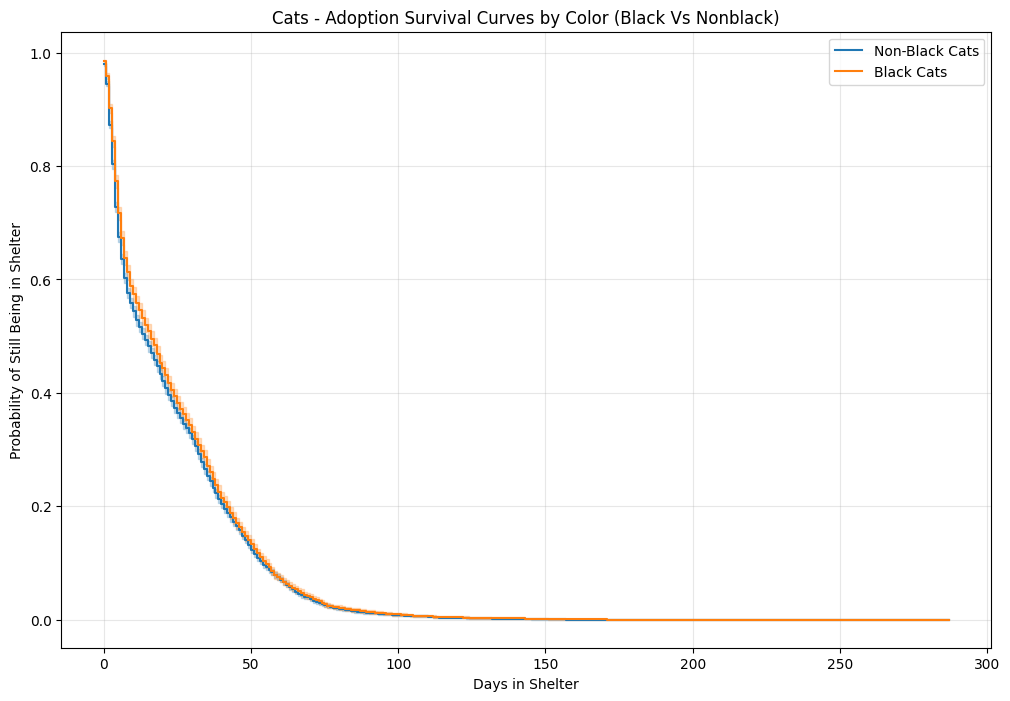


Log-rank test results:
Test statistic: 9.9650
p-value: 0.001595
*** SIGNIFICANT difference in adoption survival curves ***

DOGS - Black Vs Nonblack Analysis:
--------------------------------------------------
Non-Black: 7806 animals, 6940 adopted (88.9%)
Black: 2920 animals, 2593 adopted (88.8%)

Non-Black Dogs:
  Median time to adoption: 7.0 days
  Probability of adoption by day 7: 56.6%
  Probability of adoption by day 14: 75.0%
  Probability of adoption by day 30: 88.7%

Black Dogs:
  Median time to adoption: 6.0 days
  Probability of adoption by day 7: 57.5%
  Probability of adoption by day 14: 73.9%
  Probability of adoption by day 30: 87.7%

Black Dogs:
  Median time to adoption: 6.0 days
  Probability of adoption by day 7: 57.5%
  Probability of adoption by day 14: 73.9%
  Probability of adoption by day 30: 87.7%


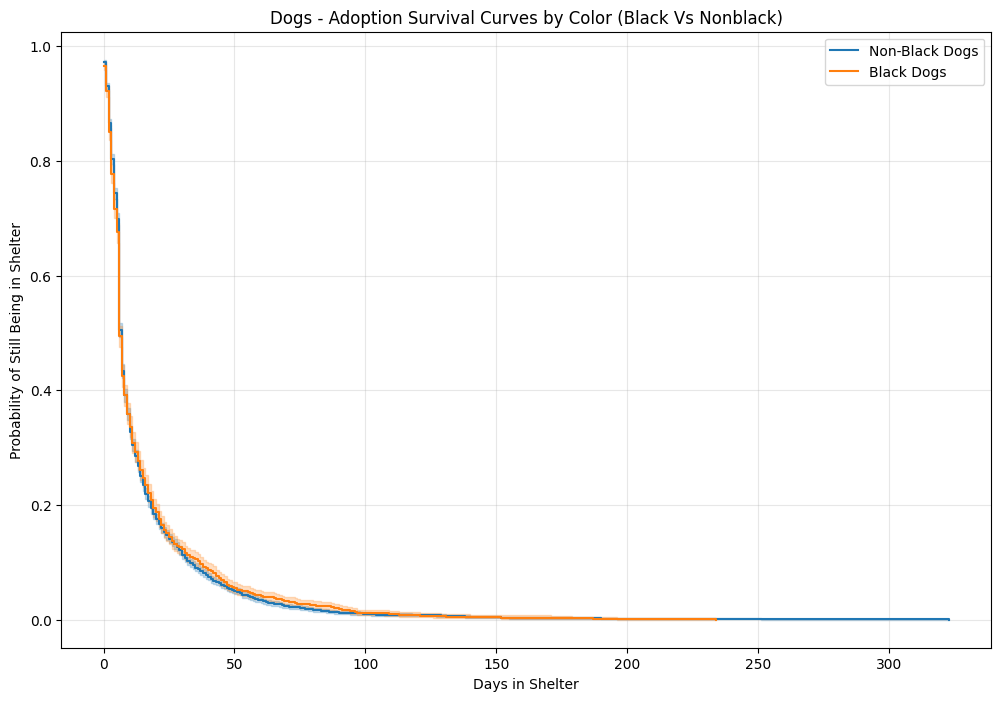


Log-rank test results:
Test statistic: 0.1424
p-value: 0.705858
No significant difference in adoption survival curves


In [66]:
# Kaplan-Meier Survival Analysis for Black vs Non-Black
print("=" * 70)
print("KAPLAN-MEIER SURVIVAL ANALYSIS: BLACK VS NON-BLACK")
print("=" * 70)

def kaplan_meier_analysis(df, species_name, color_comparison="black_vs_nonblack"):
    """Perform Kaplan-Meier survival analysis"""
    
    # Prepare data - use all animals, not just adopted
    survival_data = df.copy()
    
    # Create event indicator (1 = adopted, 0 = other outcome)
    survival_data['adopted'] = (survival_data['Outcome Type'] == 'Adoption').astype(int)
    
    if color_comparison == "black_vs_nonblack":
        survival_data['color_group'] = (survival_data['Primary Color'] == 'Black').astype(int)
        group_labels = {0: 'Non-Black', 1: 'Black'}
    else:  # dark_vs_light
        survival_data['color_group'] = survival_data['is_dark'].astype(int)
        group_labels = {0: 'Light', 1: 'Dark'}
    
    print(f"\n{species_name.upper()} - {color_comparison.replace('_', ' ').title()} Analysis:")
    print("-" * 50)
    
    # Group counts
    for group_id, label in group_labels.items():
        group_data = survival_data[survival_data['color_group'] == group_id]
        adopted_count = group_data['adopted'].sum()
        total_count = len(group_data)
        print(f"{label}: {total_count} animals, {adopted_count} adopted ({adopted_count/total_count*100:.1f}%)")
    
    # Fit Kaplan-Meier curves for each group
    kmf = KaplanMeierFitter()
    
    plt.figure(figsize=(12, 8))
    
    for group_id, label in group_labels.items():
        group_data = survival_data[survival_data['color_group'] == group_id]
        
        # Fit the survival curve
        kmf.fit(durations=group_data['length_of_stay'], 
                event_observed=group_data['adopted'], 
                label=f'{label} {species_name}')
        
        # Plot the survival curve
        kmf.plot_survival_function()
        
        # Print survival statistics
        median_survival = kmf.median_survival_time_
        print(f"\n{label} {species_name}:")
        print(f"  Median time to adoption: {median_survival:.1f} days")
        
        # Survival probabilities at key time points
        survival_at_7 = kmf.predict(7)
        survival_at_14 = kmf.predict(14)
        survival_at_30 = kmf.predict(30)
        
        print(f"  Probability of adoption by day 7: {(1-survival_at_7)*100:.1f}%")
        print(f"  Probability of adoption by day 14: {(1-survival_at_14)*100:.1f}%")
        print(f"  Probability of adoption by day 30: {(1-survival_at_30)*100:.1f}%")
    
    plt.title(f'{species_name} - Adoption Survival Curves by Color ({color_comparison.replace("_", " ").title()})')
    plt.xlabel('Days in Shelter')
    plt.ylabel('Probability of Still Being in Shelter')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    # Log-rank test for significant differences
    group_0_data = survival_data[survival_data['color_group'] == 0]
    group_1_data = survival_data[survival_data['color_group'] == 1]
    
    results = logrank_test(group_0_data['length_of_stay'], group_1_data['length_of_stay'],
                          group_0_data['adopted'], group_1_data['adopted'])
    
    print(f"\nLog-rank test results:")
    print(f"Test statistic: {results.test_statistic:.4f}")
    print(f"p-value: {results.p_value:.6f}")
    
    if results.p_value < 0.05:
        print("*** SIGNIFICANT difference in adoption survival curves ***")
    else:
        print("No significant difference in adoption survival curves")
    
    return results

# Perform analysis for both species - Black vs Non-Black
cat_survival_black = kaplan_meier_analysis(cat_df, "Cats", "black_vs_nonblack")
dog_survival_black = kaplan_meier_analysis(dog_df, "Dogs", "black_vs_nonblack")


KAPLAN-MEIER SURVIVAL ANALYSIS: DARK VS LIGHT COLORS

CATS - Dark Vs Light Analysis:
--------------------------------------------------
Light: 4751 animals, 4679 adopted (98.5%)
Dark: 12150 animals, 12014 adopted (98.9%)

Light Cats:
  Median time to adoption: 13.0 days
  Probability of adoption by day 7: 40.3%
  Probability of adoption by day 14: 51.1%
  Probability of adoption by day 30: 68.2%

Dark Cats:
  Median time to adoption: 15.0 days
  Probability of adoption by day 7: 37.9%
  Probability of adoption by day 14: 49.2%
  Probability of adoption by day 30: 67.7%


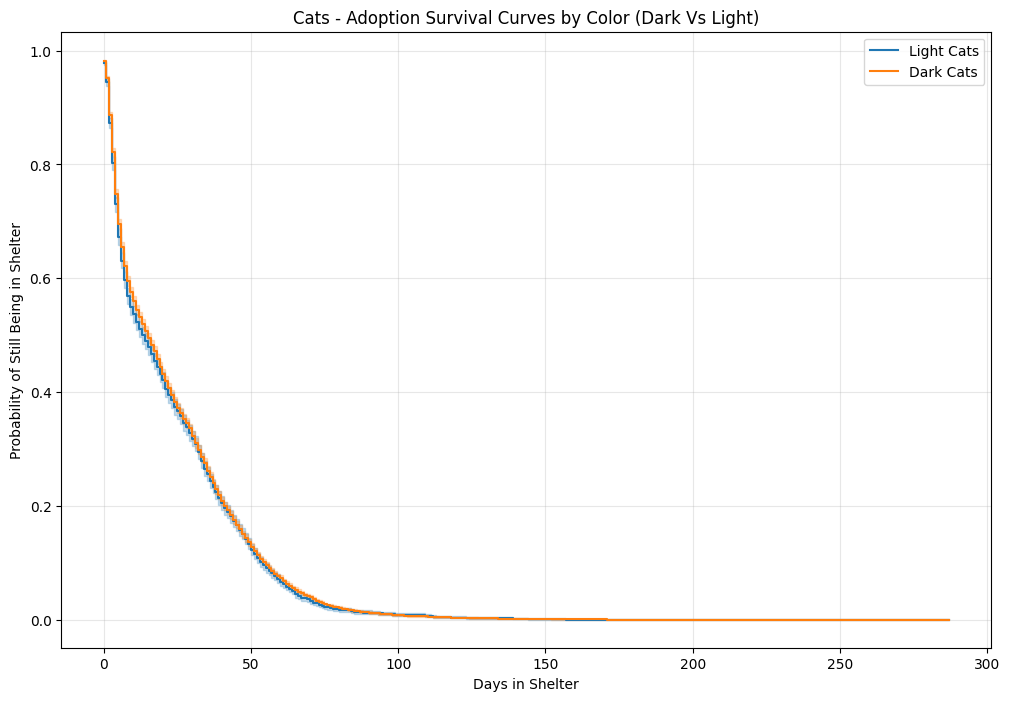


Log-rank test results:
Test statistic: 3.2991
p-value: 0.069319
No significant difference in adoption survival curves

DOGS - Dark Vs Light Analysis:
--------------------------------------------------
Light: 4148 animals, 3653 adopted (88.1%)
Dark: 6578 animals, 5880 adopted (89.4%)

Light Dogs:
  Median time to adoption: 6.0 days
  Probability of adoption by day 7: 58.3%
  Probability of adoption by day 14: 76.9%
  Probability of adoption by day 30: 89.2%

Dark Dogs:
  Median time to adoption: 7.0 days
  Probability of adoption by day 7: 55.9%
  Probability of adoption by day 14: 73.3%
  Probability of adoption by day 30: 88.0%

Dark Dogs:
  Median time to adoption: 7.0 days
  Probability of adoption by day 7: 55.9%
  Probability of adoption by day 14: 73.3%
  Probability of adoption by day 30: 88.0%


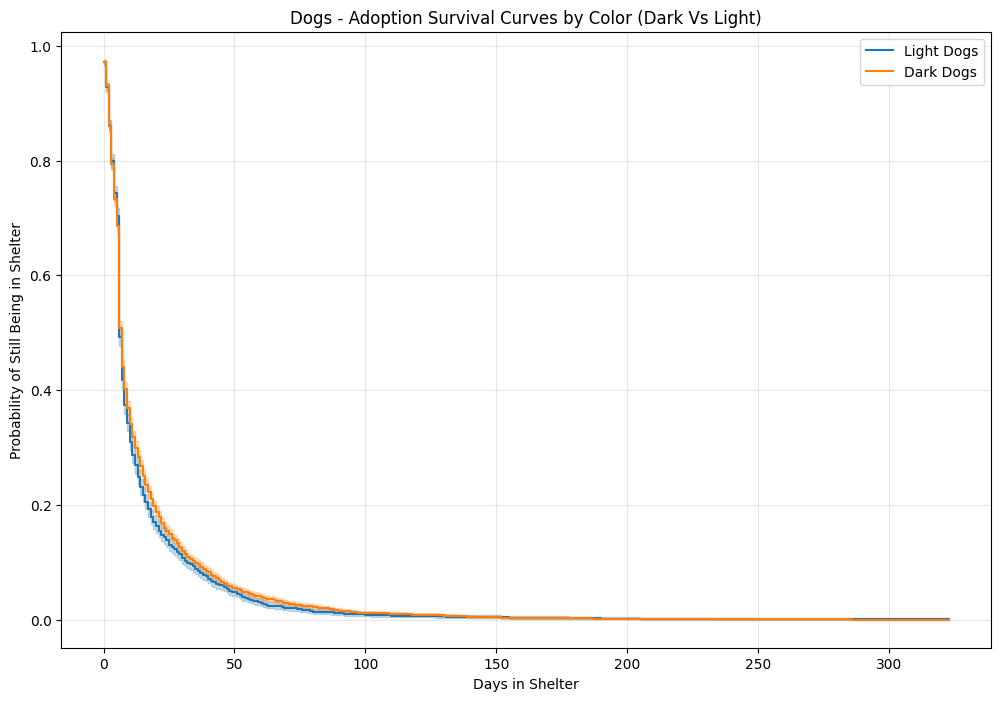


Log-rank test results:
Test statistic: 5.9727
p-value: 0.014529
*** SIGNIFICANT difference in adoption survival curves ***


In [67]:
# Kaplan-Meier Survival Analysis for Dark vs Light Colors
print("\n" + "=" * 70)
print("KAPLAN-MEIER SURVIVAL ANALYSIS: DARK VS LIGHT COLORS")
print("=" * 70)

# Perform analysis for both species - Dark vs Light
cat_survival_dark = kaplan_meier_analysis(cat_df, "Cats", "dark_vs_light")
dog_survival_dark = kaplan_meier_analysis(dog_df, "Dogs", "dark_vs_light")

## Hazard Ratio Analysis

Hazard ratios provide a more intuitive interpretation of survival differences. A hazard ratio > 1 indicates higher adoption rate (better outcome), while < 1 indicates lower adoption rate (worse outcome).

In [68]:
# Cox Proportional Hazards Analysis
try:
    from lifelines import CoxPHFitter
except ImportError:
    print("CoxPHFitter already imported with lifelines")

print("=" * 70)
print("COX PROPORTIONAL HAZARDS ANALYSIS")
print("=" * 70)

def cox_proportional_hazards_analysis(df, species_name):
    """Perform Cox Proportional Hazards analysis"""
    
    # Prepare data
    cox_data = df.copy()
    cox_data['adopted'] = (cox_data['Outcome Type'] == 'Adoption').astype(int)
    cox_data['is_black'] = (cox_data['Primary Color'] == 'Black').astype(int)
    
    # Select variables for Cox model
    cox_variables = ['length_of_stay', 'adopted', 'is_black', 'is_dark']
    
    # Add age if available
    if 'Age (Months)' in cox_data.columns:
        cox_data = cox_data.dropna(subset=['Age (Months)'])
        cox_variables.append('Age (Months)')
    
    # Create model dataset
    model_data = cox_data[cox_variables].dropna()
    
    print(f"\n{species_name.upper()} - Cox Proportional Hazards Model:")
    print("-" * 50)
    print(f"Sample size: {len(model_data)} animals")
    
    # Fit Cox model
    cph = CoxPHFitter()
    
    try:
        cph.fit(model_data, duration_col='length_of_stay', event_col='adopted')
        
        print(f"\nModel Summary:")
        print(cph.summary)
        
        # Extract key results
        hazard_ratios = cph.hazard_ratios_
        confidence_intervals = cph.confidence_intervals_
        p_values = cph.summary['p']
        
        print(f"\nHazard Ratios and Confidence Intervals:")
        for variable in ['is_black', 'is_dark']:
            if variable in hazard_ratios.index:
                hr = hazard_ratios[variable]
                ci_lower = confidence_intervals.loc[variable, 'lower-bound']
                ci_upper = confidence_intervals.loc[variable, 'upper-bound']
                p_val = p_values[variable]
                
                print(f"{variable}: HR = {hr:.3f} (95% CI: {ci_lower:.3f}-{ci_upper:.3f}), p = {p_val:.4f}")
                
                if variable == 'is_black':
                    if hr > 1:
                        print(f"  → Black {species_name.lower()} have {hr:.1f}x higher adoption rate")
                    else:
                        print(f"  → Black {species_name.lower()} have {1/hr:.1f}x lower adoption rate")
                
                if variable == 'is_dark':
                    if hr > 1:
                        print(f"  → Dark {species_name.lower()} have {hr:.1f}x higher adoption rate")
                    else:
                        print(f"  → Dark {species_name.lower()} have {1/hr:.1f}x lower adoption rate")
        
        # Model fit statistics
        print(f"\nModel Statistics:")
        print(f"Concordance Index: {cph.concordance_index_:.3f}")
        print(f"Log-likelihood: {cph.log_likelihood_:.2f}")
        
        return cph
        
    except Exception as e:
        print(f"Cox model fitting failed: {e}")
        return None

# Perform Cox analysis for both species
cat_cox_model = cox_proportional_hazards_analysis(cat_df, "Cats")
dog_cox_model = cox_proportional_hazards_analysis(dog_df, "Dogs")

COX PROPORTIONAL HAZARDS ANALYSIS

CATS - Cox Proportional Hazards Model:
--------------------------------------------------
Sample size: 16901 animals

Model Summary:
                  coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                     
is_black     -0.049089   0.952097  0.018275       -0.084907       -0.013270   
is_dark      -0.009027   0.991013  0.019292       -0.046839        0.028784   
Age (Months)  0.004865   1.004877  0.000315        0.004247        0.005483   

              exp(coef) lower 95%  exp(coef) upper 95%  cmp to          z  \
covariate                                                                   
is_black                 0.918598             0.986817     0.0  -2.686121   
is_dark                  0.954241             1.029202     0.0  -0.467933   
Age (Months)             1.004256             1.005498     0.0  15.427873   

                         p    -log2(p)  
covariate

## Time-to-Adoption Benchmarks

Analysis of adoption speed benchmarks to understand practical implications of any color bias detected.

In [69]:
# Time-to-adoption benchmarks analysis
print("=" * 70)
print("TIME-TO-ADOPTION BENCHMARKS")
print("=" * 70)

def adoption_speed_benchmarks(df, species_name):
    """Analyze adoption speed benchmarks by color"""
    
    adopted = df[df['Outcome Type'] == 'Adoption'].copy()
    
    print(f"\n{species_name.upper()} - Adoption Speed Analysis:")
    print("-" * 50)
    
    # Define speed categories
    adopted['adoption_speed'] = pd.cut(adopted['length_of_stay'], 
                                     bins=[0, 3, 7, 14, 30, float('inf')],
                                     labels=['Same Week (0-3 days)', 'Fast (4-7 days)', 
                                            'Moderate (8-14 days)', 'Slow (15-30 days)', 
                                            'Very Slow (30+ days)'])
    
    # Overall speed distribution
    speed_dist = adopted['adoption_speed'].value_counts(normalize=True) * 100
    print(f"\nOverall Adoption Speed Distribution:")
    for speed, pct in speed_dist.items():
        print(f"  {speed}: {pct:.1f}%")
    
    # Speed by color groups
    print(f"\nAdoption Speed by Color Group:")
    
    # Black vs Non-Black
    black_speed = adopted[adopted['Primary Color'] == 'Black']['adoption_speed'].value_counts(normalize=True) * 100
    nonblack_speed = adopted[adopted['Primary Color'] != 'Black']['adoption_speed'].value_counts(normalize=True) * 100
    
    print(f"\nBlack vs Non-Black {species_name}:")
    speed_comparison = pd.DataFrame({
        'Black': black_speed,
        'Non-Black': nonblack_speed
    }).fillna(0).round(1)
    print(speed_comparison)
    
    # Dark vs Light
    dark_speed = adopted[adopted['is_dark']]['adoption_speed'].value_counts(normalize=True) * 100
    light_speed = adopted[~adopted['is_dark']]['adoption_speed'].value_counts(normalize=True) * 100
    
    print(f"\nDark vs Light {species_name}:")
    speed_comparison_dl = pd.DataFrame({
        'Dark': dark_speed,
        'Light': light_speed
    }).fillna(0).round(1)
    print(speed_comparison_dl)
    
    # Statistical test for speed differences
    from scipy.stats import chi2_contingency
    
    # Chi-square test for black vs non-black speed distribution
    speed_contingency = pd.crosstab(adopted['adoption_speed'], 
                                   adopted['Primary Color'] == 'Black')
    chi2, p_val, dof, expected = chi2_contingency(speed_contingency)
    
    print(f"\nChi-square test for adoption speed vs color:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_val:.6f}")
    
    if p_val < 0.05:
        print("*** SIGNIFICANT difference in adoption speed by color ***")
    else:
        print("No significant difference in adoption speed by color")
    
    return adopted

# Analyze adoption speed for both species
cat_speed_data = adoption_speed_benchmarks(cat_df, "Cats")
dog_speed_data = adoption_speed_benchmarks(dog_df, "Dogs")

TIME-TO-ADOPTION BENCHMARKS

CATS - Adoption Speed Analysis:
--------------------------------------------------

Overall Adoption Speed Distribution:
  Very Slow (30+ days): 32.4%
  Fast (4-7 days): 20.8%
  Slow (15-30 days): 18.4%
  Same Week (0-3 days): 16.9%
  Moderate (8-14 days): 11.5%

Adoption Speed by Color Group:

Black vs Non-Black Cats:
                      Black  Non-Black
adoption_speed                        
Same Week (0-3 days)   14.4       18.2
Fast (4-7 days)        21.1       20.6
Moderate (8-14 days)   12.0       11.2
Slow (15-30 days)      19.3       18.0
Very Slow (30+ days)   33.2       32.1

Dark vs Light Cats:
                      Dark  Light
adoption_speed                   
Same Week (0-3 days)  16.4   18.3
Fast (4-7 days)       20.6   21.0
Moderate (8-14 days)  11.6   11.1
Slow (15-30 days)     18.8   17.5
Very Slow (30+ days)  32.6   32.1

Chi-square test for adoption speed vs color:
Chi-square statistic: 38.6466
p-value: 0.000000
*** SIGNIFICANT differen

# Length of Stay Analysis Summary

This analysis examined whether coat color affects adoption timing at Jacksonville Humane Society using survival analysis and multiple statistical approaches.

## Results

**Cats**
Black cats wait longer for adoption than non-black cats. Median wait times are 16 days for black cats versus 14 days for non-black cats. The survival analysis shows significant differences (p=0.0015), with black cats having a 4.8% lower adoption rate (HR = 0.952). Only 36.3% of black cats are adopted within the first week compared to 39.7% of non-black cats. Both groups achieve 98.8% adoption rates.

**Dogs**
No evidence of black dog bias. Black dogs have faster median adoption times (6 vs 7 days) and higher first-week adoption rates (57.5% vs 56.6%). Survival analysis shows no significant difference (p=0.699). However, when examining all dark colors versus light colors, dark-colored dogs show 8.2% lower adoption rates (HR = 0.918, p<0.001).

**Adoption Speed**
Among cats, 33.2% of black cats wait more than 30 days compared to 32.1% of non-black cats. For dogs, differences in speed categories are minimal. Chi-square tests show significant associations between color and adoption speed for both species, but effect sizes are small.

## Statistical Validation

Multiple approaches (t-tests, Mann-Whitney U tests, ANOVA, survival analysis) support these findings. Non-parametric tests confirmed parametric results despite non-normal data distributions. Cox models controlled for age effects while quantifying adoption rate differences.

## Interpretation

Jacksonville Humane Society shows minimal color bias compared to national patterns. While black cats experience modestly longer waits, all color groups achieve high adoption success. The 2-day median difference for cats and absent bias for black dogs indicates effective shelter practices that prioritize individual animal characteristics over color preferences.